In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle
from scipy.spatial import KDTree
import glob
%matplotlib inline

In [6]:
### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

In [2]:
folder_HMF = '/pscratch/sd/j/jialiu/CAMELS/Rockstar/' ### original, unorganized halo catalogue from rockstar
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'
folder_plot = home+'plots/'

cmap = matplotlib.cm.get_cmap('Spectral') #('viridis')#
labels=[r'$\Omega_m$', r'$\sigma_8$', r'$\log_{10}(A_{\rm SN1})$', r'$\log_{10}(A_{\rm AGN1})$', r'$\log_{10}(A_{\rm SN2})$', r'$\log_{10}(A_{\rm AGN2})$']

mbins = linspace(8,16, 17)
dmbin = mbins[1]-mbins[0]
mbins_center = mbins[:-1]+0.5*dmbin


In [18]:
########## in this cell, I use symlink to match Astri naming (1P_0, 1P_1..1P_66) to TNG/SIMBA naming (1P_1_n5, etc)
# ### TNG sims
# sim_name_TNG = np.loadtxt(home+'params/params_1P_TNG.txt', usecols=(0), dtype='U') ## the simulation names, e.g. "1P_1_n5"
# sim_params_TNG = np.loadtxt(home+'params/params_1P_TNG.txt', usecols=range(1,7)) ## the actual parameters, corresponding to the sim names above
# #### change all the baryon parameters to log
# sim_params_TNG = concatenate([sim_params_TNG[:,:2], log10(sim_params_TNG[:,2:])],axis=1)

# ##### Astrid names
# sim_name_Astrid = np.loadtxt(home+'params/params_1P_Astrid.txt', usecols=(0), dtype='U') ## the simulation names, e.g. "1P_1_n5"
# sim_params_Astrid = np.loadtxt(home+'params/params_1P_Astrid.txt', usecols=range(1,7)) ## the actual parameters, corresponding to the sim names above
# #### change all the baryon parameters to log
# sim_params_Astrid = concatenate([sim_params_Astrid[:,:2], log10(sim_params_Astrid[:,2:])],axis=1)

# amax(abs(sim_params_TNG-sim_params_Astrid))

# print (sim_name_TNG)

# os.system ('echo $0')
# # os.system ("bash -c 'echo $0'")

# for i in range(len(sim_name_TNG)):
#     os.system ("cd /global/u1/j/jialiu/cosmo_dep_feedback/CAMELS/Rockstar/Astrid/1P; echo ln -sf %s %s" % (sim_name_Astrid[i], sim_name_TNG[i]))
#     os.system ("cd /global/u1/j/jialiu/cosmo_dep_feedback/CAMELS/Rockstar/Astrid/1P; ln -sf %s %s" % (sim_name_Astrid[i], sim_name_TNG[i]))

(5030, 9) [ 8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5 16. ]


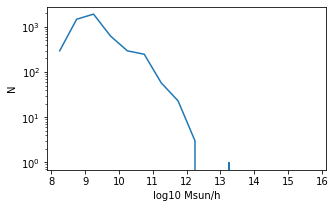

In [7]:
####### debugging cell, take a look at a sample halo catalogue

#scale(0) id(1) desc_scale(2) desc_id(3) num_prog(4) pid(5) upid(6) desc_pid(7) phantom(8) sam_Mvir(9) Mvir(10) 
# Rvir(11) rs(12) vrms(13) mmp?(14) scale_of_last_MM(15) vmax(16) x(17) y(18) z(19) vx(20) vy(21) 
# vz(22) Jx(23) Jy(24) Jz(25) Spin(26) Breadth_first_ID(27) Depth_first_ID(28) Tree_root_ID(29) Orig_halo_ID(30) 
# Snap_idx(31) Next_coprogenitor_depthfirst_ID(32) Last_progenitor_depthfirst_ID(33) Last_mainleaf_depthfirst_ID(34) 
# Tidal_Force(35) Tidal_ID(36) Rs_Klypin(37) Mvir_all(38) M200b(39) M200c(40) M500c(41) M2500c(42) Xoff(43) Voff(44) 
# Spin_Bullock(45) b_to_a(46) c_to_a(47) A[x](48) A[y](49) A[z](50) b_to_a(500c)(51) c_to_a(500c)(52) A[x](500c)(53) 
# A[y](500c)(54) A[z](500c)(55) T/|U|(56) M_pe_Behroozi(57) M_pe_Diemer(58) Type(59) SM(60) Gas(61) BH_Mass(62) Macc(63) 
# Mpeak(64) Vacc(65) Vpeak(66) Halfmass_Scale(67) Acc_Rate_Inst(68) Acc_Rate_100Myr(69) Acc_Rate_1*Tdyn(70) Acc_Rate_2*Tdyn(71) 
# Acc_Rate_Mpeak(72) Acc_Log_Vmax_Inst(73) Acc_Log_Vmax_1*Tdyn(74) Mpeak_Scale(75) Acc_Scale(76) First_Acc_Scale(77) 
# First_Acc_Mvir(78) First_Acc_Vmax(79) Vmax\@Mpeak(80) Tidal_Force_Tdyn(81) Log_(Vmax/Vmax_max(Tdyn;Tmpeak))(82) 
# Time_to_future_merger(83) Future_merger_MMP_ID(84)

test_fn = '/global/homes/j/jialiu/cosmo_dep_feedback/CAMELS/Rockstar/Astrid/1P/1P_0/hlists/hlist_1.00000.list'
hmf = np.loadtxt(test_fn, usecols=[1, 10, 11, 12, 17, 18, 19, 26, 47])
# id(1), Mvir(10), Rvir(11), rs(12), x(17) y(18) z(19), Spin(26),c_to_a(47)

print (hmf.shape, mbins)
dmdn,y=histogram(log10(hmf[:,1]), bins=mbins)
f, ax=subplots(1,1, figsize=(5,3))
ax.plot(mbins_center,dmdn)
ax.set_yscale('log')
ax.set_xlabel('log10 Msun/h')
ax.set_ylabel('N')
show()

In [9]:
########## debugging cell for matching rockstart a to input z
# import glob
# listing = glob.glob('C:/foo/bar/foo.log*')

# rock_folder = '/pscratch/sd/j/jialiu/CAMELS/Rockstar/Astrid/1P/1P_1_n5/hlists/'
# # file_list = os.listdir(rock_folder)
# file_list = glob.glob(rock_folder+'hlist*')
# file_list[0][-12:-5]
# file_list

# a_arr = np.array([float(x[-12:-5]) for x in file_list])
# a_arr

In [8]:
# cat_fn_gen = lambda isim, iLH, ia: folder_HMF+'%s/%s/%s/hlists/hlist_%.5f.list'%(isim, iLH[:2], iLH, ia)
# cat_DM_fn_gen = lambda isim, iLH, ia: folder_HMF+'%s_DM/%s/%s/hlists/hlist_%.5f.list'%(isim, iLH[:2], iLH, ia)

########## for certain folder and redshift, list out all the available rockstar a and put the closest a to the input a
####### this is to deal with the Pk redshifts don't always match up with rockstar redshifts (or a)

def cat_fn_gen (isim, iLH, ia, DM=''):
    rock_folder = folder_HMF+'%s%s/%s/%s/hlists/'%(isim, DM, iLH[:2], iLH)
    file_list = glob.glob(rock_folder+'hlist*')
    a_arr = np.array([float(x[-12:-5]) for x in file_list])
    diff_a = abs(ia-a_arr)
    a_match = a_arr[where(diff_a==amin(diff_a))]
    return rock_folder+'hlist_%.5f.list'%(a_match)

def cat_DM_fn_gen (isim, iLH, ia):
    return cat_fn_gen (isim, iLH, ia, DM='_DM')

cat_fn_gen ('IllustrisTNG', '1P_1_0', 0.99)
cat_DM_fn_gen ('IllustrisTNG', '1P_1_0', 0.99)

'/pscratch/sd/j/jialiu/CAMELS/Rockstar/IllustrisTNG_DM/1P/1P_1_0/hlists/hlist_1.00000.list'

Text(0, 0.5, 'PDF')

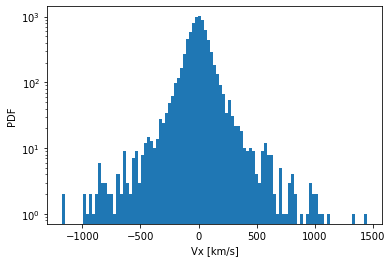

In [10]:
######## take a quick look at the amplitude of velocities, so I know how much weight to put on v when match halos

isim, iLH, iz = 'IllustrisTNG', '1P_1_0', 0
ia = 1/(1+iz)
cat_fn_1 = cat_fn_gen (isim, iLH, ia)
cat_fn_2 = cat_DM_fn_gen (isim, iLH, ia)

cat1_pos = np.loadtxt(cat_fn_1, usecols=[17, 18, 19])
cat2_pos = np.loadtxt(cat_fn_2, usecols=[17, 18, 19])

cat1_mvir = log10(np.loadtxt(cat_fn_1, usecols=[10]))
cat2_mvir = log10(np.loadtxt(cat_fn_2, usecols=[10]))

cat1_v = np.loadtxt(cat_fn_1, usecols=[20, 21, 22])
cat2_v = np.loadtxt(cat_fn_2, usecols=[20, 21, 22])

hist (cat2_v[:,0],bins=101)
yscale('log')
xlabel('Vx [km/s]')
ylabel('PDF')

# print (amin(cat1_pos,axis=0), amax(cat1_pos,axis=0))
# amin(cat2_v,axis=0) , amax(cat2_v, axis=0)
# hist (cat2_v[:,0],bins=101)
# concatenate([cat1_pos, cat1_v],axis=1).shape

not good, do not use


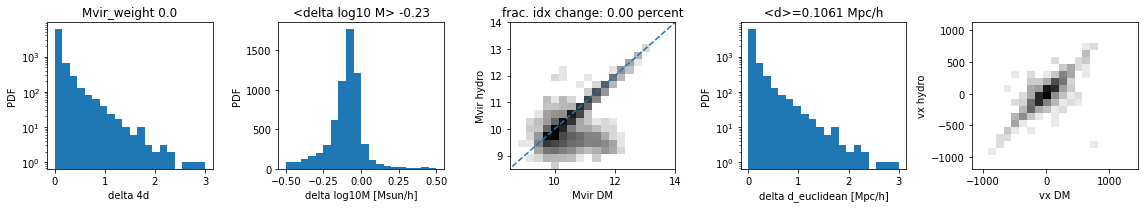

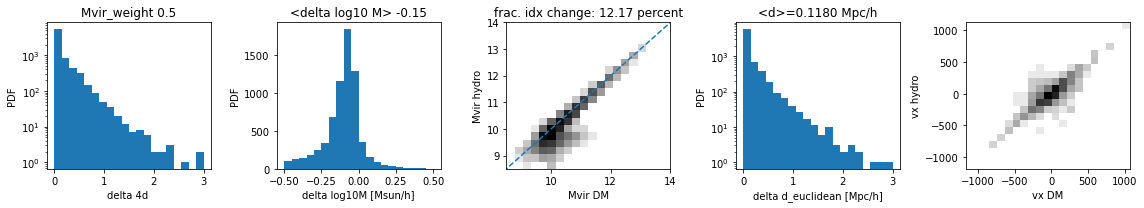

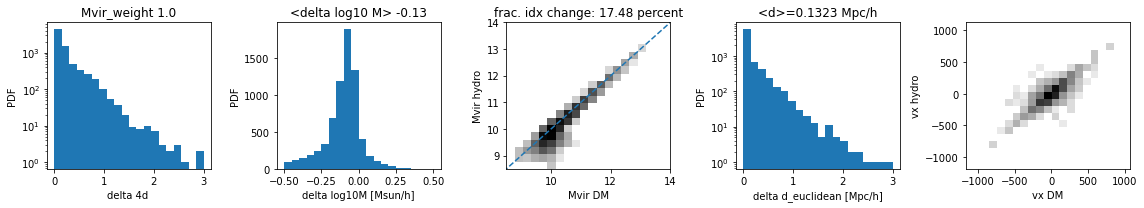

In [12]:
######## not good, do not use
######## try with both Mvir + pos fit
######## (1) first try 4D search, treating mass as 4th dimension
######## (2) try 3D fit and find maybe 5 nearest neighbor, within them find the closest in mass

print ('not good, do not use')
Mvir_weight = 1 ## weights on Mvir, compared to pos when finding distance... shouldn't be too high, otherwise overpower by mass

for Mvir_weight in (0, 0.5, 1 ):#, 5): #(0., 0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5):
    M_pos = lambda cat1_mvir, cat1_pos: concatenate([Mvir_weight*cat1_mvir.reshape(-1,1),cat1_pos],axis=1)

    tree = KDTree(M_pos(cat2_mvir, cat2_pos)) ##position of hydros
    dd, ii = tree.query(M_pos(cat1_mvir, cat1_pos), k=1)#, distance_upper_bound=3) ## for DMO halos, find corresponding hydro halos, distance bound is just to help the search
    dd_euc = sqrt(sum((cat1_pos - cat2_pos[ii])**2, axis=1))
    
    if Mvir_weight == 0:
        ii0 = ii
        # dd_euc_mean0 = mean(dd_euc)
        
    f, ax = subplots(1,5,figsize=(16,3))

    ax[0].hist(dd, bins=linspace(0,3, 21))
    ax[0].set_xlabel('delta 4d ')
    ax[0].set_yscale('log')
    ax[0].set_ylabel('PDF')
    ax[0].set_title('Mvir_weight %.1f'%(Mvir_weight))

    ax[1].hist(cat1_mvir - cat2_mvir[ii], bins=linspace(-0.5,0.5,21))
    ax[1].set_xlabel('delta log10M [Msun/h]')
    # ax[1].set_yscale('log')
    ax[1].set_ylabel('PDF')
    ax[1].set_title('<delta log10 M> %.2f' %( mean(cat1_mvir - cat2_mvir[ii])))

    ax[2].hist2d(cat2_mvir[ii], cat1_mvir,bins=linspace(8.5, 14, 21),norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)
    ax[2].plot([8,14],[8,14],'--')
    # ax[2].scatter(cat1_mvir[ii], cat2_mvir,s=5)
    ax[2].set_xlabel('Mvir DM')
    ax[2].set_ylabel('Mvir hydro')
    ax[2].set_title('frac. idx change: %.2f percent' % (100*sum(ii!=ii0)/len(ii)))
    
    ax[3].hist(dd_euc, bins=linspace(0,3, 21))
    ax[3].set_xlabel('delta d_euclidean [Mpc/h]')
    ax[3].set_yscale('log')
    ax[3].set_ylabel('PDF')
    ax[3].set_title('<d>=%.4f Mpc/h' % (mean(dd_euc)))
    
    ax[4].hist2d(cat2_v[ii,0], cat1_v[:,0], bins=21,norm=mpl.colors.LogNorm(), cmap=mpl.cm.binary)
    ax[4].plot([0,0.5],[0,0.5],'--')
    ax[4].set_xlabel('vx DM')
    ax[4].set_ylabel('vx hydro')

    plt.tight_layout()

In [13]:
#############################################################
########## above cels are tests, below are production codes
#############################################################

In [14]:
def cat_match_fun (cat_fn_dm, cat_fn_hydro, wv = 0.01):
    '''Match the 1st catalogues to the 2nd, based on their position and velocity.
    Input: 
    cat_fn_dm: file name of the base catalogue
    cat_fn_hydro: file name of the catalogue to match to base
    wv: weights on velocity to match the amplitude of the positions
    output:     [idx_dm, idx_hydro]
    indices for cat1 and cat2 to match, such at pos[idx1], pos[idx2] return the positions of matched samples'''
    
    cat_dm_pos = np.loadtxt(cat_fn_dm, usecols=[17, 18, 19])
    cat_hydro_pos = np.loadtxt(cat_fn_hydro, usecols=[17, 18, 19])
    
    N1 = len(cat_hydro_pos)
    
    cat_dm_v = np.loadtxt(cat_fn_dm, usecols=[20, 21, 22])
    cat_hydro_v = np.loadtxt(cat_fn_hydro, usecols=[20, 21, 22])
    
    tree = KDTree(concatenate([cat_dm_pos, cat_dm_v*wv],axis=1))
    dd, ii = tree.query(concatenate([cat_hydro_pos, cat_hydro_v*wv],axis=1), k=1)# 
    
    dd_euc = sqrt(sum((cat_dm_pos[ii] - cat_hydro_pos)**2, axis=1))
    v_euc = sqrt(sum((cat_dm_v[ii] - cat_hydro_v)**2, axis=1))

    cat_dm_mvir = log10(np.loadtxt(cat_fn_dm, usecols=[10]))
    cat_hydro_mvir = log10(np.loadtxt(cat_fn_hydro, usecols=[10]))

    cat_dm_Rvir = np.loadtxt(cat_fn_dm, usecols=[11])
    cat_hydro_Rvir = np.loadtxt(cat_fn_hydro, usecols=[11])
    
    cat_dm_Rs = np.loadtxt(cat_fn_dm, usecols=[12])
    cat_hydro_Rs = np.loadtxt(cat_fn_hydro, usecols=[12])

    cat_dm_c2a = np.loadtxt(cat_fn_dm, usecols=[47])
    cat_hydro_c2a = np.loadtxt(cat_fn_hydro, usecols=[47])
    # id(1), Mvir(10), Rvir(11), rs(12), x(17) y(18) z(19), Spin(26),c_to_a(47)

    return arange(N1), ii, dd_euc, v_euc, cat_dm_mvir[ii], cat_hydro_mvir, cat_dm_Rvir[ii], cat_hydro_Rvir, cat_dm_Rs[ii], cat_hydro_Rs, cat_dm_c2a[ii], cat_hydro_c2a 


In [15]:
### organize the files
def return_hmf (fn, mbins=mbins):
    cat = np.loadtxt(fn, usecols=[10])
    hmf = histogram(log10(cat), bins=mbins)[0]
    return hmf  
    
cat_matched_fn_gen = lambda isim, iLH, iz: home+'halos/matched/%s_%s_z=%.2f_matched.npy'%(isim, iLH, iz)
Nbin=len(mbins)-1

def return_Mvir_binned_match (fn, mbins=mbins):
    ''' get each 1P file, for each Mvir bin, get e.g. the mean M_hydro/M_dm, and std
    return [mean_ratio_Mvir, std_ratio_Mvir, 
            mean_ratio_Rvir, std_ratio_Rvir, 
            mean_ratio_Cvir, std_ratio_Cvir,
            mean_ratio_c2a, std_ratio_c2a,
            mean_d, std_d, std_v]
    '''
    cat_full = np.load(fn).T
    cat_full = cat_full[~np.isnan( mean(cat_full,axis=-1))]
    
    mvir = cat_full[:, 4]
    
    ## 0-arange(N1), 1-ii, 2-dd_euc, 3-v_euc, 4-cat_dm_mvir[ii], 5-cat_hydro_mvir, 
    ## 6-cat_dm_Rvir[ii], 7-cat_hydro_Rvir, 8-cat_dm_Rs[ii], 9-cat_hydro_Rs, 
    ## 10-cat_dm_c2a[ii], 11-cat_hydro_c2a
    out = zeros(shape=(11, Nbin))
    for i in range(Nbin):

        idx = where( (mbins[i]<mvir) & (mbins[i+1]>mvir) )[0] ## find indices fall within mbin, for mvir_DMO
        cat = cat_full[idx].T
        out[0, i] = mean(cat[5]/cat[4]) ## mvir
        out[1, i] = std(cat[5]/cat[4])
        out[2, i] = mean(cat[7]/cat[6]) ## rvir
        out[3, i] = std(cat[7]/cat[6])
        out[4, i] = mean( (cat[7]/cat[9]) / (cat[6]/cat[8])) ##cvir=cvir/cs
        out[5, i] = std( (cat[7]/cat[9]) / (cat[6]/cat[8]))
        out[6, i] = mean(cat[11]/cat[10]) ## c2a
        out[7, i] = std(cat[11]/cat[10])
        out[8, i] = mean(cat[2]) ## mean dd_euc
        out[9, i] = std(cat[2]) ## std dd_euc
        out[10, i] = std(cat[3]) ## std v_euc
    return out

matched_field_names = ['mean_ratio_Mvir', 'std_ratio_Mvir', 
            'mean_ratio_Rvir', 'std_ratio_Rvir', 
            'mean_ratio_Cvir', 'std_ratio_Cvir',
            'mean_ratio_c2a', 'std_ratio_c2a',
            'mean_d', 'std_d', 'std_v']

Nf=len(matched_field_names)

def organize_HMF (iz, isim, iset='1P', organize_matched=1):
    '''For each halo cat, return both the Mass-binned HMF, as well as abundance matched halos; check for hydro if only CDM particles are used..?'''
    ia=1/(1+iz)

    sim_name = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=(0), dtype='U') ## the simulation names, e.g. "1P_1_n5"
    sim_params = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=range(1,7)) ## the actual parameters, corresponding to the sim names above
    #### change all the baryon parameters to log
    sim_params = concatenate([sim_params[:,:2], log10(sim_params[:,2:])],axis=1)
    #### select only the set (1P, LH, or CV)
    idx = where(np.char.find(sim_name, iset)!=-1)
    sim_name = sim_name[idx]
    sim_params = sim_params[idx]
  
    ############### load all the hmf in next line, takes long time
    ## Astrid/1P/1P_0/hlists/hlist_1.00000.list'
    hmf_arr = array([return_hmf(cat_fn_gen (isim, iLH, ia)) for iLH in sim_name])
    hmf_DM_arr = array([return_hmf(cat_DM_fn_gen (isim, iLH, ia)) for iLH in sim_name])
        
    # for iset in ('LH', '1P', 'CV'): ##('1P', ): ##
    ifn=home+'halos/%s_%s_z=%.2f.npy'%(isim, iset, iz)
    ifn_DM=home+'halos/%s_%s_z=%.2f_DM.npy'%(isim, iset, iz)
    if not os.path.isfile(ifn):
        data_arr = concatenate([sim_params, hmf_arr],axis=1) ## include params and hmf
        save(ifn, data_arr)
        print ('%s, %s set has %i models, data shape %s'%(isim, iset, len(idx[0]), data_arr.shape))
    if not os.path.isfile(ifn_DM):
        data_DM_arr = concatenate([sim_params, hmf_DM_arr],axis=1) ## include params and hmf
        save(ifn_DM, data_DM_arr)
    print ('Done HMF calc.')
    
    ################## matched halos, by each model
    for iLH in sim_name:
        cat_fn_hydro = cat_fn_gen (isim, iLH, ia)
        cat_fn_dm = cat_DM_fn_gen (isim, iLH, ia)
        # ifn_matched_iLH = home+'halos/%s_%s_z=%.2f_matched.npy'%(isim, iLH, iz)
        ifn_matched_iLH = cat_matched_fn_gen (isim, iLH, iz)
        if not os.path.isfile(ifn_matched_iLH):
            print (iLH)
            arr_matched_iLH = cat_match_fun (cat_fn_dm, cat_fn_hydro)
            save(ifn_matched_iLH, arr_matched_iLH)
    print ('Done mathcing halo by each model')
    
    ################ organize matched halos, per mbin, for all models, by properties (mvir, rvir, cvir, c2a)
    if organize_matched:
        
        out_arr = array([return_Mvir_binned_match(cat_matched_fn_gen (isim, iLH, iz)) for iLH in sim_name])
        for i in range(Nf):
            data_arr = concatenate([sim_params, out_arr[:,i,:]],axis=1)
            ifn_matched = home+'halos/%s_binned_z=%.2f_%s.npy'%(isim, iz, matched_field_names[i])
            save(ifn_matched, data_arr)    
        print ('Done organize matched halos into mvir, rvir, cvir, c2a',isim, iz)

In [16]:
######### debugging cell

# out
# iset = '1P'
# sim_name = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=(0), dtype='U') ## the simulation names, e.g. "1P_1_n5"
# sim_params = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=range(1,7)) ## the actual parameters, corresponding to the sim names above
# #### change all the baryon parameters to log
# sim_params = concatenate([sim_params[:,:2], log10(sim_params[:,2:])],axis=1)


# idx = where(np.char.find(sim_name, iset)!=-1)
# sim_name = sim_name[idx]
# sim_params = sim_params[idx]

# sim_name

# out_arr = array([return_Mvir_binned_match(cat_matched_fn_gen (isim, iLH, iz)) for iLH in sim_name])

In [17]:
################################################
############ mass processing cell ###########
################################################


######## all CAMELS sims
sim_arr =  ['Astrid', 'IllustrisTNG','SIMBA',]  #,   ## seems like Astrid files are there, but naming system is different

######### the redshift we're interested in
zarr= [0.00, 1.05, 2.00, 3.00] #, 0.05, 0.10, 0.15] #
# zarr = [0.00,]
# zarr = [1.05, 2.00, 3.00] 
####### organize the files, take long #########
for isim in sim_arr:
    for iz in zarr:
        print (isim, iz)
        organize_HMF (iz, isim)

Astrid 0.0
Astrid, 1P set has 66 models, data shape (66, 22)
passed HMF calc.
passed mathcing halo by each model
Astrid 0.0


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2

In [325]:
######### debuggin cell

# print (out_arr.shape)
# print (out_arr[11])
# iLH = sim_name[0]
# print (iLH)
# return_Mvir_binned_match(cat_matched_fn_gen (isim, iLH, iz))

# # matched_field_names = ['mean_ratio_Mvir', 'std_ratio_Mvir', 
# #             'mean_ratio_Rvir', 'std_ratio_Rvir', 
# #             'mean_ratio_Cvir', 'std_ratio_Cvir',
# #             'mean_ratio_c2a', 'std_ratio_c2a',
# #             'mean_d', 'std_d', 'std_v']

# # Nbin=len(mbins)-1
# # Nbin

# iLH = '1P_1_0'
# fn=cat_matched_fn_gen (isim, iLH, iz)

# cat_full = np.load(fn).T
# print (cat_full.shape)
# cat_full = cat_full[~np.isnan( mean(cat_full,axis=-1))]

# print (cat_full.shape)

# for i in range(12):
#     print (cat_full[0,i])
# mvir = cat_full[:, 4]
# print (mvir, amax(mvir), amin(mvir))

# # Nbin=len(mbins)-1
# # ## 0-arange(N1), 1-ii, 2-dd_euc, 3-v_euc, 4-cat_dm_mvir[ii], 5-cat_hydro_mvir, 
# # ## 6-cat_dm_Rvir[ii], 7-cat_hydro_Rvir, 8-cat_dm_Rs[ii], 9-cat_hydro_Rs, 
# # ## 10-cat_dm_c2a[ii], 11-cat_hydro_c2a
# out = zeros(shape=(11, Nbin))
# for i in range(Nbin):
#     idx = where( (mbins[i]<mvir) & (mbins[i+1]>mvir) )[0] ## find indices fall within mbin, for mvir_DMO
#     print (mbins[i], len(idx))
#     cat = cat_full[idx].T
#     out[0, i] = mean(cat[5]/cat[4]) ## mvir
#     out[1, i] = std(cat[5]/cat[4])
#     out[2, i] = mean(cat[7]/cat[6]) ## rvir
#     out[3, i] = std(cat[7]/cat[6])
#     out[4, i] = mean( (cat[7]/cat[9]) / (cat[6]/cat[8])) ##cvir=cvir/cs
#     out[5, i] = std( (cat[7]/cat[9]) / (cat[6]/cat[8]))
#     out[6, i] = mean(cat[11]/cat[10]) ## c2a
#     out[7, i] = std(cat[11]/cat[10])
#     out[8, i] = mean(cat[2]) ## mean dd_euc
#     out[9, i] = std(cat[2]) ## std dd_euc
#     out[10, i] = std(cat[3]) ## std v_euc
# out

/tmp/ipykernel_22220/1058254486.py:15: RuntimeWarning: divide by zero encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
/tmp/ipykernel_22220/1058254486.py:15: RuntimeWarning: invalid value encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]


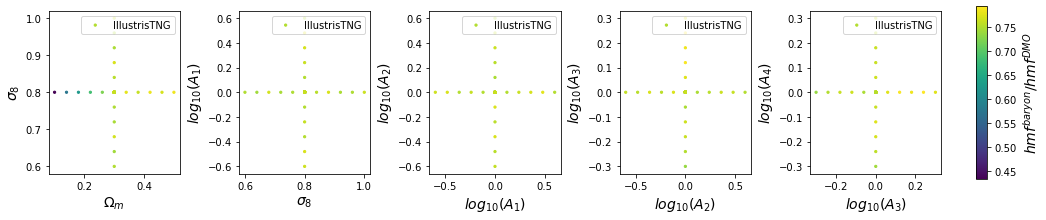

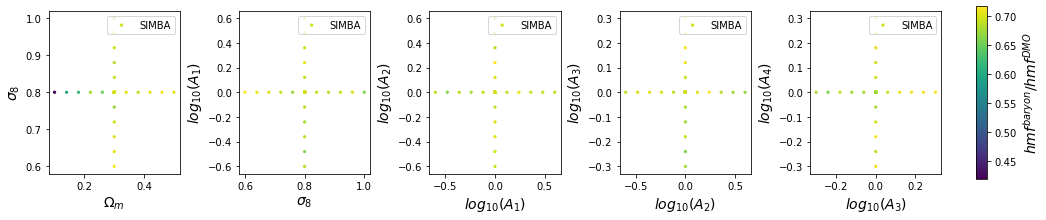

In [8]:
########### validation

iz = 0
iset = '1P'
isim = 'IllustrisTNG'
ix=5 ## m bin to look at ratio

for isim in sim_arr:
    ifn=home+'halos/%s_%s_z=%.2f.npy'%(isim, iset, iz)
    ifn_DM=home+'halos/%s_%s_z=%.2f_DM.npy'%(isim, iset, iz)
    hmf_arr = np.load(ifn)
    hmf_DM_arr = np.load(ifn_DM)
    hmf_arr.shape

    params = hmf_arr[:, :6]
    r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
    rprox = r[:, ix]
    im=mbins[ix]
    # params.shape, r.shape, rprox.shape

    f, ax=subplots(1,5, figsize=(16,3))

    for i in range(5):
        im=ax[i].scatter(params.T[i], params.T[i+1], c=rprox, label=isim, s=5)
        ax[i].set_xlabel(labels[i], fontsize=14)
        ax[i].set_ylabel(labels[i+1],fontsize=14)   
        ax[i].legend()
    cbar_ax = f.add_axes([0.93, 0.1, 0.01, 0.8])
    f.colorbar(im, cax=cbar_ax)
    f.subplots_adjust(wspace=0.45)
    cbar_ax.set_ylabel(r'$hmf^{baryon}/hmf^{DMO}$',fontsize=14)
    show()

/tmp/ipykernel_22220/909906371.py:11: RuntimeWarning: divide by zero encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
/tmp/ipykernel_22220/909906371.py:11: RuntimeWarning: invalid value encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]


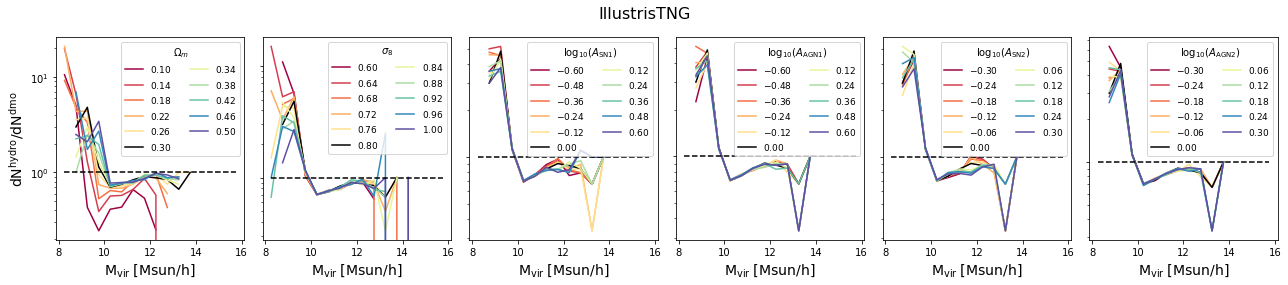

/tmp/ipykernel_22220/909906371.py:11: RuntimeWarning: divide by zero encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
/tmp/ipykernel_22220/909906371.py:11: RuntimeWarning: invalid value encountered in true_divide
  r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]


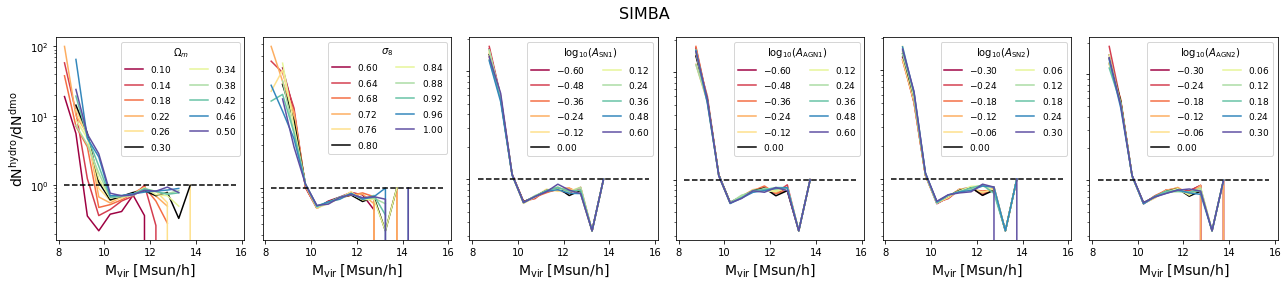

In [16]:
fidu_params = [ 0.3, 0.8 ,0. ,  0. ,0. ,0.]

for isim in ['IllustrisTNG', 'SIMBA']:
    ifn=home+'halos/%s_%s_z=%.2f.npy'%(isim, iset, iz)
    ifn_DM=home+'halos/%s_%s_z=%.2f_DM.npy'%(isim, iset, iz)
    hmf_arr = np.load(ifn)
    hmf_DM_arr = np.load(ifn_DM)
    hmf_arr.shape

    params = hmf_arr[:, :6]
    r = hmf_arr[:, 6:]/hmf_DM_arr[:, 6:]
    params.shape, hmf_arr.shape

    f, axes=subplots(1, 6, figsize=(18,4))
    for i in range(6): ## number of parameters
        ax=axes.reshape(-1)[i]
        idx = where(params[:,i]!=fidu_params[i])[0] # select the varying one on specific parameter
        idx = concatenate([idx[:5], [0,], idx[5:]]) ## inserting the fiducial model in the middle
        j=0
        colors = cmap(linspace(0,1,len(idx)))
        for iidx in idx:
            icolor=colors[j]
            if j==5: ## fiducial model
                icolor='k'
            iparam=params[iidx,i]
            ax.plot(mbins_center, r[iidx], c=icolor,label='$%.2f$'%(iparam))
            j+=1
            
        ax.legend(title='%s'%(labels[i]),ncol=2,fontsize=9,loc='upper right')
        ax.set_yscale('log')
        # ax.set_ylim(0.5, 1.1)
        # ax.set_xlim(0.12, 25)
        ax.set_xlabel(r'$\rm M_{vir} \;[Msun/h]$',fontsize=14)
        ax.plot(mbins_center, ones(len(mbins_center)), 'k--')
        
        if i == 0:
            # ax.set_title(isim,fontsize=14)
            ax.set_ylabel(r'$\rm dN^{hydro}/dN^{dmo}$',fontsize=14)
        else:
            ax.yaxis.set_ticklabels([])
    f.suptitle(isim, fontsize=16)        
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    show()